In [28]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load files

In [ ]:
import pandas as pd
import cv2
import matplotlib.pyplot as plt

tile_meta_filename="data/tile_meta.csv"
wsi_meta_filename="data/wsi_meta.csv"
labels_filename="data/polygons.jsonl"

tile_meta = pd.read_csv(tile_meta_filename)
wsi_meta = pd.read_csv(wsi_meta_filename)
labels = pd.read_json(labels_filename, lines=True)
labels.set_index(['id'], inplace=True)
tile_meta.set_index(['id'], inplace=True)
wsi_meta.set_index(['source_wsi'], inplace=True)

# Process

In [ ]:
from utils.utils import labels_to_masks

# Create masks for blood vessels
masks = labels_to_masks(labels, include=['blood_vessel'])
masks = masks[masks['blood_vessel'].notna()]['blood_vessel']

# Remove tiles which don't have blood_vessels labeled
meta = tile_meta[tile_meta.index.isin(masks.index)]

In [ ]:
import numpy as np

from utils.utils import label_to_mask

id = "0ba172f33ea6"
x = cv2.imread(f"data/train/{id}.tif", cv2.IMREAD_GRAYSCALE)
y = masks.loc[id]

plt.imshow(y)
plt.show()

In [6]:
from utils.data_loading import HubmapDataset
from pathlib import Path
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import random
import torch
from torch.utils.data import DataLoader, random_split, Subset
import os

labels_file = Path('./data/polygons.jsonl')
dir_img = Path('./data/train/')
dir_mask = Path('./data/train_masks/')

dataset = HubmapDataset(labels_file, dir_img, dir_mask, scale=0.5)

# 2. Ignore some data to speed up testing
dataset = Subset(dataset, random.sample(
    range(0, len(dataset)), int(len(dataset)*(1-0.9))))

# 3. Split into train / validation partitions
n_val = int(len(dataset) * 0.1)
n_train = len(dataset) - n_val
train_set, val_set = random_split(
    dataset, [n_train, n_val], generator=torch.Generator().manual_seed(0))

# 4. Create data loaders
loader_args = dict(batch_size=1,
                    num_workers=os.cpu_count(), pin_memory=True)
train_loader = DataLoader(train_set, shuffle=True, **loader_args)
val_loader = DataLoader(val_set, shuffle=False,
                        drop_last=True, **loader_args)


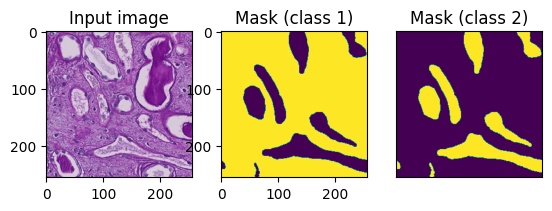

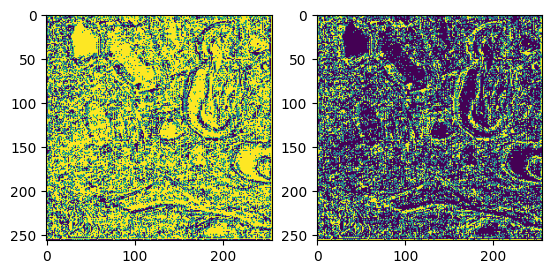

In [32]:
from unet import UNet
from utils.utils import plot_img_and_mask
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch import optim
import torch.nn as nn

device = torch.device('cpu')

model = UNet(n_channels=3, n_classes=2, bilinear=False)
model = model.to(memory_format=torch.channels_last)
model.to(device=device)

for batch in train_loader:
    model.train()
    images, true_masks = batch['image'], batch['mask']

    images = images.to(device=device, dtype=torch.float32, memory_format=torch.channels_last)
    true_masks = true_masks.to(device=device, dtype=torch.long)

    masks_pred = model(images)

    x = images.cpu()[0].numpy().transpose((1,2,0))
    y = true_masks.cpu()[0].numpy()
    mask_pred = F.one_hot(masks_pred.argmax(dim=1), model.n_classes).permute(0, 3, 1, 2).float()
    y_pred = mask_pred.cpu().detach().numpy()

    plot_img_and_mask(x,y)

    fig, ax = plt.subplots(1, 2)
    ax[0].imshow(y_pred[0][0])
    ax[1].imshow(y_pred[0][1])
    plt.show()
    break